In [1]:
# Dependencies should be installed with miniconda/anaconda because some require native libraries that are tedious to build
# $ conda env create -f environment.yml

import geopandas as gp
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Load the topology file

g = nx.read_graphml("Cogentco.graphml")
nodes = {"id": [], "geometry": []}
edges = []

def refer_previous_attrs(node):
    attrs = g.nodes[str(node)]
    if "Latitude" not in attrs or "Longitude" not in attrs:
        return refer_previous_attrs(node-1)
    else:
        return attrs

for node, attrs in g.nodes(data=True):
    if "Latitude" not in attrs or "Longitude" not in attrs:
        attrs = refer_previous_attrs(int(node)-1)

    lat1, lon1 = attrs["Longitude"], attrs["Latitude"]
    nodes["id"].append(int(node))
    nodes["geometry"].append(Point(lat1, lon1))

    for src, dst in g.edges(node):
        attrs = g.nodes[dst]

        if "Latitude" not in attrs or "Longitude" not in attrs:
            attrs = refer_previous_attrs(int(dst)-1)

        lat2, lon2 = attrs["Longitude"], attrs["Latitude"]
        edges.append(LineString([(lat1, lon1), (lat2, lon2)]))

In [3]:
# Load and clip the map. The map files are downloaded from: https://www.naturalearthdata.com/
world = gp.read_file("ne_10m_admin_0_countries")
world = gp.clip(world, (-140, 0, 50, 75))

<Axes: >

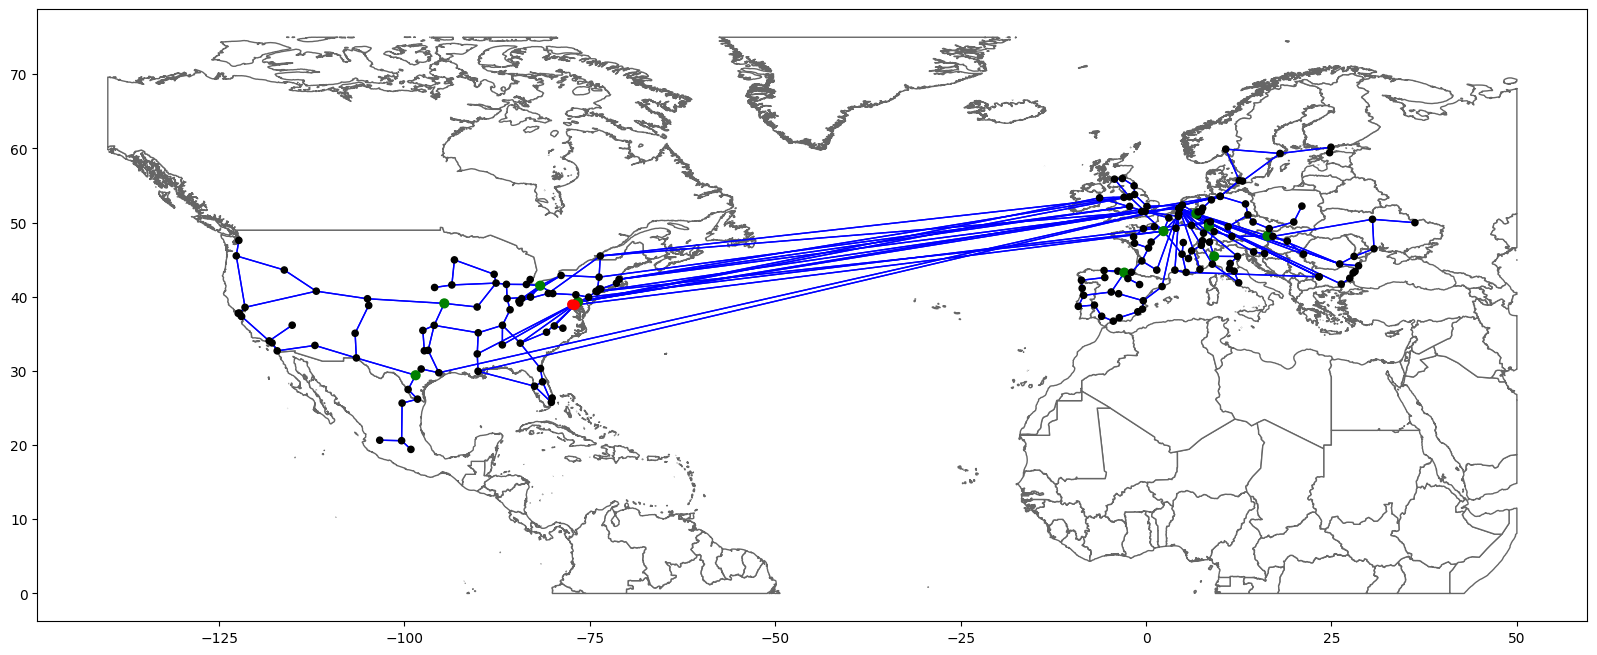

In [4]:
base = world.plot(figsize=(20, 10), color="white", edgecolor=(0.4, 0.4, 0.4))

# Draw the edges
gdf = gp.GeoSeries(edges)
gdf.plot(ax=base, color="blue", linewidth=1)

# Draw the nodes
gdf = gp.GeoDataFrame(nodes)
# Add a new column indicating the color of each node. Nodes in red_nodes and green_nodes are colored red and green in this case.
red_nodes = [146, 154, 159]
green_nodes = [3, 7, 14, 26, 37, 61, 134, 150, 154, 162, 183]
gdf["color"] = gdf["id"].map(lambda i: "red" if i in red_nodes else ("green" if i in green_nodes else "black"))
markers = gdf["id"].map(lambda i: 40 if i in red_nodes or i in green_nodes else 20)
gdf.plot(ax=base, color=gdf["color"], markersize=markers, zorder=2)